# **Calculating Stoner-Wohlfarth Curves for Isotropic Polycrystals**

The SW-model is strictly valid for single-domain particles or ensembles of non-interacting, single-domain particles.

An ensemble of single-domain particles is considered isotropic if all possible values of $\theta_{H}$ are present with equal frequency *i.e.* the particles are randomly oriented. In this case, magnetisation curves measured parallel to various sample axes are exactly the same.

We can construct a model for such a material by calculating SW-curves for many values of $\theta_{H}$ and combining them.

<br>

First, the usual import and settings:

In [1]:
import numpy
import matplotlib.pyplot as plt
from scipy.optimize import minimize

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rc('font', size=10)
plt.rc('figure', figsize=(6,4))

Here are the functions `SW_E`and `getData_single`from the previous notebook:

In [2]:
def SW_E(thetaM, thetaH, H, M0, K1, K2):
    """
    Calculate the energy per unit volume resulting from the
    balance of the anisotropy energy and Zeeman energy, given
    the arguments.
    
    Args:
        thetaM = angle in degrees between the magnetisation and the applied field
        thetaH = angle in degrees between the easy axis and the applied field
        H = applied field in Oe
        M0 = spontaneous magnetisation in erg/Oe.cm^3 (== kA/m)
        K1 = second order anisotropy constant in erg/cm^3
        K2 = fourth order anisotropy constant in erg/cm^3
    
    Returns: 
        E = float, the energy per unit volume for the conditions given, unit: erg/cm^3.
    """
    t1 = K1*numpy.sin(numpy.deg2rad(thetaM-thetaH))**2
    t2 = K2*numpy.sin(numpy.deg2rad(thetaM-thetaH))**4
    t3 = M0*H*numpy.cos(numpy.deg2rad(thetaM))
    return t1+t2-t3

In [3]:
def getData_single(FR, M0, K1, K2, thetaH):
    """
    For each value of the field in the field range (FR), find the minimum
    of the absolute value of the derivative of the energy equation with
    respect to the angle theta.
    
    Args:
        FR : array of applied field values in Oe
        thetaH = angle in degrees between the easy axis and the applied field
        M0 = spontaneous magnetisation in erg/Oe.cm^3 (== kA/m)
        K1 = second order anisotropy constant in erg/cm^3
        K2 = fourth order anisotropy constant in erg/cm^3
        
    Returns:
        D : a list of angles theta in degrees at which the derivative of the energy
            equation is zero for the field values defined in FR
    """
    D = []
    IG = thetaH
    for H in FR:
        q = minimize(SW_E, IG, args=(thetaH, H, M0, K1, K2), method="Nelder-Mead")
        D.append(q.x[0])
        IG = q.x[0]

        
    return D

<br>

### SW-curves at different values of $\theta_{H}$

In [4]:
# Values for the experimental dataset of an isotropic polycrystal
M0 = 855 # erg/Oecm^3 == kA/m
K1 = 1.941e7 # erg/cm^3
K2 = 0.181e7 # erg/cm^3

In [5]:
# field range (start, stop, step) in Oe
FR = numpy.arange(0, 14.25e4, 2.5e3)

Having defined the necessary constants, we can now calculate SW-cuves for several values of $\theta_{H}$:

In [6]:
D0 = getData_single(FR, M0, K1, K2, 0.0)
D30 = getData_single(FR, M0, K1, K2, 30.0)
D60 = getData_single(FR, M0, K1, K2, 60.0)
D75 = getData_single(FR, M0, K1, K2, 75.0)
D90 = getData_single(FR, M0, K1, K2, 90.0)

Text(0, 0.5, '$\\mathregular{\\frac{M}{M_{0}}}$')

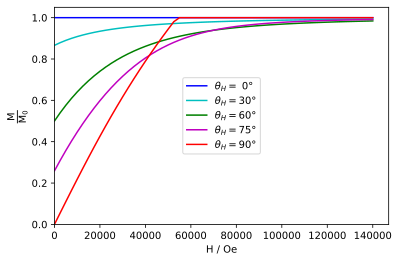

In [7]:
plt.plot(FR, numpy.cos(numpy.deg2rad(D0)), 'b-', label=r"$\theta_{H} = \ 0\degree$")
plt.plot(FR, numpy.cos(numpy.deg2rad(D30)), 'c-', label=r"$\theta_{H} = 30\degree$")
plt.plot(FR, numpy.cos(numpy.deg2rad(D60)), 'g-', label=r"$\theta_{H} = 60\degree$")
plt.plot(FR, numpy.cos(numpy.deg2rad(D75)), 'm-', label=r"$\theta_{H} = 75\degree$")
plt.plot(FR, numpy.cos(numpy.deg2rad(D90)), 'r-', label=r"$\theta_{H} = 90\degree$")
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.legend(loc="center")
plt.xlabel("H / Oe")
plt.ylabel(r"$\mathregular{\frac{M}{M_{0}}}$", size=14)

We have seen the extreme cases of $\theta_{H}$ = [0, 90] from the previous notebook. Curves for other values of $\theta_{H}$ start at $H$ = 0 Oe, from values of $\frac{M}{M_{0}}$ in the range [0, 1].

<br>

### Combining several curves to represent a randomly oriented polycrystal

In order to generate a SW-model for an isotropic polycrystal, we need to combine SW-curves for many different values of $\cos\theta_{H}$ .

We define a new function which calls `getData_single` for all the values of $\cos\theta_{H}$ which we define in a range TR.

In [8]:
def getData_multi(TR, FR, M0, K1, K2):
    """
    For each value of thetaH in the range of angles (TR), and 
    for each value of the field in the field range (FR), find the minimum
    of the absolute value of the derivative of the energy equation with
    respect to the angle theta.
    
    Args:
        TR : array of the cosines of the angles thetaH
        FR : array of applied field values in Oe
        M0 : spontaneous magnetisation in erg/Oe.cm^3 (== kA/m)
        K1 : second order anisotropy constant in erg/cm^3
        K2 : fourth order anisotropy constant in erg/cm^3
        
    Returns:
        data_all : a dict whose keys are the angles thetaH in degrees and whose values
                   are a list of angles thetaM in degrees at which the energy per unit volume
                   is minimum for the field values defined in FR.
    """
    data_all = {}   
    for thetaH in numpy.rad2deg(numpy.arccos(TR)):
        D = getData_single(FR, M0, K1, K2, thetaH)
        data_all[str(thetaH)] = D
        
    return data_all

In [9]:
TR = numpy.arange(0.0,1.01,0.02)

In [10]:
data_all = getData_multi(TR, FR, M0, K1, K2)

<br>

Now we need a function which will find the average value of these curves at each field value:

In [11]:
def getAvearageCurve(data_all):
    """
    Compute and return the mean of a number of Stoner-Wohlfarth
    curves.
    
    Args:
        data_all : dict, where the keys are angles thetaH in degrees and the values are
                   lists of angles thetaM for various field values
                   
    Returns:
        data_ave : array of mean angles thetaM
    """
    data_ave = numpy.zeros((len(data_all.keys()), len(FR)))
    K = list(data_all.keys())
    for i in range(len(K)):
        data_ave[i] = numpy.cos(numpy.deg2rad(data_all[K[i]]))

    data_ave = numpy.mean(data_ave, axis=0)
    
    return data_ave

In [12]:
data_ave = getAvearageCurve(data_all)

Text(0.5, 1.0, 'SW-curve for an isotropic polycrystal')

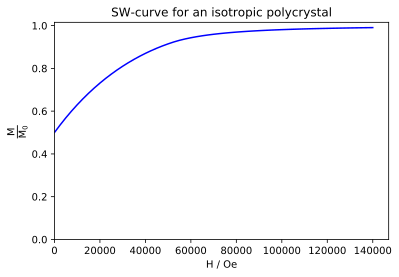

In [13]:
plt.plot(FR,data_ave,'b-')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel("H / Oe")
plt.ylabel(r"$\mathregular{\frac{M}{M_{0}}}$", size=14)
plt.title("SW-curve for an isotropic polycrystal")

The result of the averaging process is a curve which starts at $\frac{M}{M_{0}}$ = 0.5 for H = 0. This is the correct result for polycrystals with uniaxial anisotropy - the remanence is approximately half the saturation magnetisation.

<br>

Now we can compare the calculated curve with an experimental measurement of an isotropic polycrystal of the same material. The experiental data are saved in the folder "resources".

In [14]:
pc = numpy.loadtxt("resources/polycrystal_isotropic.txt")

Text(0, 0.5, 'M / kA/m')

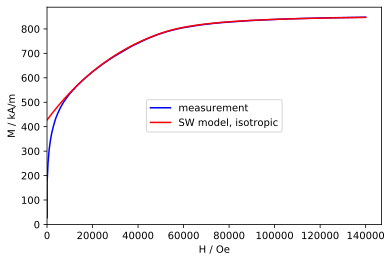

In [15]:
plt.plot(pc[:,0], pc[:,1], 'b-', label="measurement")
plt.plot(FR, data_ave*M0, 'r-', label="SW model, isotropic")
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)
plt.legend(loc="center")
plt.xlabel("H / Oe")
plt.ylabel("M / kA/m")

We have a very good fit between our SW-curve for an isotropic material and the experimental data as long as the applied field is higher than about 17000 Oe. The discrepancy at lower field values is due to domain wall motion in the sample, which is not considered in the SW-model.

We need to ensure that the magnetisation curves are reversible in the region which we fit with the SW-curve. This could be done by measuring curves with increasing and decreasing field and checking that the curves lie exactly on top of each other. Another method would be to visualise the domain wall motion as a function of applied field strength, e.g. with Kerr microscopy, and then only fit the region of the curve above the field strength where the last domain wall motion occurred.

For the test data shown here, the curves were fully reversible above an applied field of about 15000 Oe.